# Test Particle filters

In [952]:
using LogExpFunctions
using StatsBase
using Distributions
using Plots

In [953]:
include("ParticleFilters.jl")
include("pedigreeAproximation.jl")
include("AgeStructuredModels.jl")
include("DemographicParameters.jl")
include("AgeTraitStructuredModels.jl")
include("StockRecruitCurves.jl")
theme(:wong2)

In [954]:
mod1 = AgeStructuredModels.init(150,DemographicParameters.Smyth_2016_sr,DemographicParameters.Smyth_2016_survival,
    DemographicParameters.Smyth_16_F_vec)

Rstar = AgeStructuredModels.compute_Rstar(mod1)
k = 3.0


# set base genetic paramters
Vle = 1.0
θ = 0.0
s = 0.05
min = -5
max = 10 
Δz = 0.05

# set base paramters for propogated individuals 
μ_im = 5.0
R_im = 0.5 * Rstar  # 50% natrual recrutment 

# initialize coupled genetic-demogrpahic model 
pop = AgeTraitStructuredModels.init(mod1,Vle, θ, s, min, max, Δz)
StockRecruitCurves.update_BevetonHolt_k!(pop.ageStructure.SRCurve, k)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)
print(" ")

pop1 = pedigreeAproximation.init_population(mod1,θ,s,5,1.0)
StockRecruitCurves.update_BevetonHolt_k!(pop1.ageStructure.SRCurve, k)


pop2 = pedigreeAproximation.init_population(mod1,θ,s,5,1.0)
StockRecruitCurves.update_BevetonHolt_k!(pop1.ageStructure.SRCurve, k)


pedigreeAproximation.time_step_DSI!(pop1, 0, 5.0)
pedigreeAproximation.time_step_DSI!(pop2, 0, 5.0)
print(" ")

# test state over write function
## checks if state is over writen (plot 1) and that the new states are not linked (plot 2)

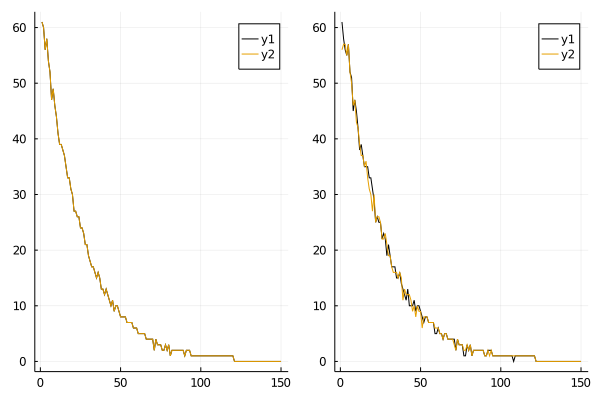

In [955]:
ParticleFilters.overwrite_state!(pop1,pop2)
p1 = Plots.plot(pop1.abundanceN)
Plots.plot!(p1, pop2.abundanceN)

pedigreeAproximation.time_step_DSI!(pop1, 0, 5.0)
pedigreeAproximation.time_step_DSI!(pop2, 0, 5.0)

p2 = Plots.plot(pop1.abundanceN)
Plots.plot!(p2, pop2.abundanceN)

plot(p1,p2)

# Simulate data 

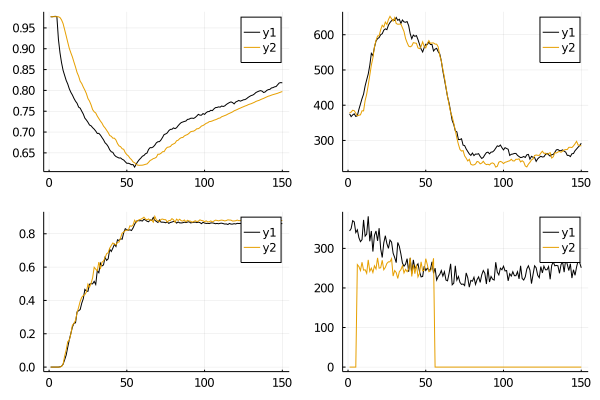

In [1031]:
include("AgeStructuredModels.jl")
include("AgentBasedSims.jl")
include("pedigreeAproximation.jl")
include("DemographicParameters.jl")
include("AgeTraitStructuredModels.jl")
include("StockRecruitCurves.jl")
using Plots
theme(:wong2)

# initialize demographic model - paramters loaded from DemographicParameters.jl 
# see tests in "TestDemographicParametersparams.ipynb"
mod1 = DemographicParameters.mod_Smyth_2016_5year #AgeStructuredModels.init(150,DemographicParameters.Smyth_2016_sr,DemographicParameters.Smyth_2016_survival,
    #DemographicParameters.Smyth_16_F_vec)

Rstar = AgeStructuredModels.compute_Rstar(mod1)
k = 1.5


# set base genetic paramters
Vle = 1.0
θ = 0.0
s = 0.15
min = -3
max = 8
Δz = 0.3

# set base paramters for propogated individuals 
p_spawn = 1.0
s = 0.05
origin = 0

# immigration parameteres 
T = 150
T_start = 5
T_end = 55
Nt = 5*100
Nt = vcat(repeat([0], T_start),repeat([Nt], T_end- T_start), repeat([0], T  - T_end))


# genetic load parameters 
μ_im = 5.0
RRS = AgeTraitStructuredModels.RRS(mu_im,s)
p_im = 0.5


popS = AgentBasedSims.init_population(mod1,p_spawn,origin,s,0.0)

Gdsn = Distributions.Normal(μ_im,1.0)


pop1 = pedigreeAproximation.init_population(mod1,  θ, s,6,1.0)


SSB = zeros(T)
W = zeros(T)

SSBdet = zeros(T)
Wdet = zeros(T)
recruitsH = zeros(T)
recruitsN = zeros(T)
pedigree = []
pedigree_det = zeros(T)

pi_levels = 0.0:(1/(pop1.m-1)):1.0
for t in 1:T
    if Nt[t] > 0
        Rim = rand(Distributions.Binomial(Nt[t],p_im))
        AgentBasedSims.time_step!(popS, Rim, Gdsn, 0.0, false)
        pedigreeAproximation.time_step_DSI!(pop1,Rim,μ_im)
    else
        AgentBasedSims.time_step!(popS, 0, Gdsn, 0.0, false)
        pedigreeAproximation.time_step_DSI!(pop1,0.0,μ_im)
    end 

    SSB[t] = AgentBasedSims.spawning_stock(popS)
    W[t] = AgentBasedSims.fitness(popS)
    SSBdet[t] = pedigreeAproximation.SSB(pop1)
    Wdet[t] = pedigreeAproximation.fitness(pop1)
    recruitsN[t],recruitsH[t] = AgentBasedSims.recruits(popS)
    push!(pedigree,AgentBasedSims.pedigree_dsn_recruits(popS))
        
    pedigree_det[t] = sum(pop1.pi[:,1] .* pi_levels)
end 

p1 = Plots.plot(W)
Plots.plot!(p1, Wdet)
p2 = Plots.plot(SSB)
Plots.plot!(p2, SSBdet)

p3 = Plots.plot(broadcast(x -> sum(x)/length(x),pedigree))
Plots.plot!(p3, pedigree_det)  
p4 = Plots.plot(recruitsN)
Plots.plot!(p4, recruitsH)
plot(p1, p2, p3,p4)

0.5000000000000003

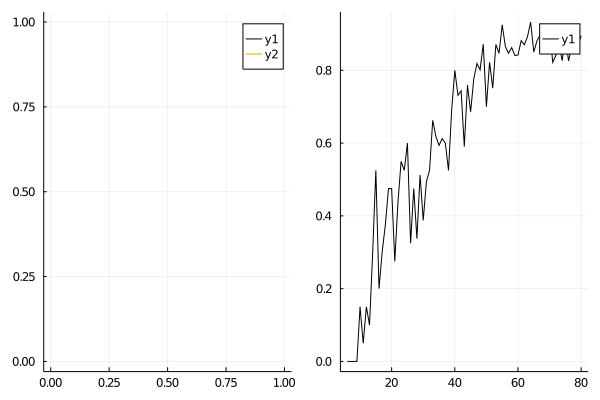

In [1032]:
time_steps_pedigree = 6:1:80
time_steps_recruitsN = []#1:1:100
time_steps_recruitsH = []#6:1:50
data_recruitsN = recruitsN[time_steps_recruitsN]
data_recruitsH = recruitsH[time_steps_recruitsH]
data_pedigree = pedigree[time_steps_pedigree]
print(" ")
p1 = Plots.plot(time_steps_recruitsN,data_recruitsN )
Plots.plot!(p1, time_steps_recruitsH,data_recruitsH)
n = 10
data_pedigree = broadcast(x -> x[1:10],data_pedigree)
p2 = Plots.plot(time_steps_pedigree,broadcast(x ->sum(x)/length(x),data_pedigree))
plot(p1,p2)

# Test likelihood functions

In [1023]:
include("pedigreeAproximation.jl")
# initialize populations 
pop1 = pedigreeAproximation.init_population(mod1,  θ, s,4,1.0)
StockRecruitCurves.update_BevetonHolt_k!(pop1.ageStructure.SRCurve, k)


T = 75
t_stock = 50
T_stock = 300

fitness = zeros(T)
SSB = zeros(T)

fitness1 = zeros(T)
SSB1 = zeros(T)

pisum = zeros(pop1.m,T)
for t in 1:T
    if t < t_stock
        piN = pedigreeAproximation.time_step_DSI!(pop1,0, μ_im)
    elseif t < T_stock
        piN =pedigreeAproximation.time_step_DSI!(pop1,rand(Distributions.Poisson(R_im)),μ_im)
    else
        piN =pedigreeAproximation.time_step_DSI!(pop1,0.0,μ_im)
    end 
end 



In [932]:
include("ParticleFilters.jl")
println(ParticleFilters.recruits_pedigree(data_pedigree[25],pop1))


-30.729954404790533


# Test particle filter likelihood estimate

In [1024]:
include("ParticleFilters.jl")
T_end = 80
agestructure = mod1
Nt = Nt
time_step! = pedigreeAproximation.time_step_DSI!
t_pedigree = time_steps_pedigree
t_recruitsN = time_steps_recruitsN
t_recruitsH = time_steps_recruitsH 

pedigrees = data_pedigree # broadcast(x -> x[1:n],data_pedigree)
recruitsN = data_recruitsN
recruitsH = data_recruitsH
presc = 1.0

data = ParticleFilters.data(T_end,agestructure,Nt,time_step!,t_pedigree,t_recruitsN,t_recruitsH,
                            pedigrees,recruitsN,recruitsH,presc)

p_im = 0.5
s = 0.05
RRS = 0.5
p_spawn = 1.0

params = ParticleFilters.params(p_im,s,RRS,p_spawn)
    
print(" ")

In [933]:

n = 20 #length(par)
loglik1 = zeros(n)
loglik2 = zeros(n)
loglik3 = zeros(n)
loglik4 = zeros(n)

for i in 1:n
    print(i, "  ")
    params = ParticleFilters.params(p_im,s,RRS,p_spawn)
    loglik1[i] = ParticleFilters.likelihood(params,data;N_particles = 10000, n = 4)
    loglik2[i] = ParticleFilters.likelihood(params,data;N_particles = 1000, n = 4)
    loglik3[i] = ParticleFilters.likelihood(params,data;N_particles = 100, n = 4)
    loglik4[i] = ParticleFilters.likelihood(params,data;N_particles = 10, n = 4)
end


1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  

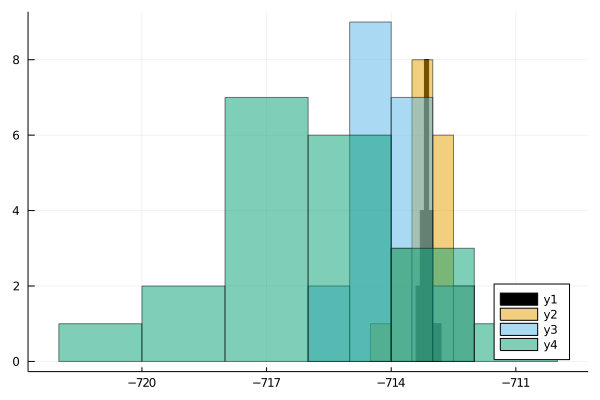

In [936]:
Plots.histogram(par ,loglik1, legend = :bottomright)
Plots.histogram!(par ,loglik2, legend = :bottomright, alpha = 0.5)
Plots.histogram!(par ,loglik3, legend = :bottomright, alpha = 0.5)
Plots.histogram!(par ,loglik4, legend = :bottomright, alpha = 0.5)

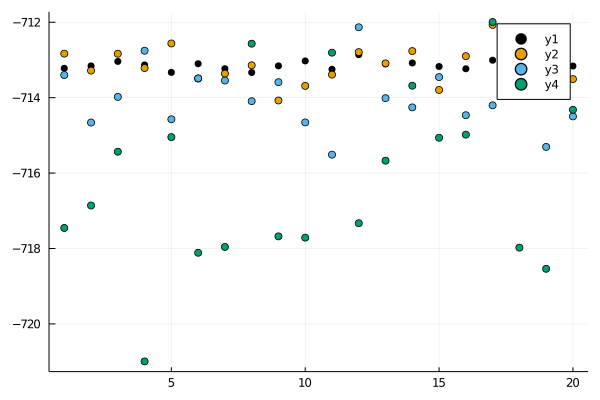

In [937]:
Plots.scatter(loglik1)
Plots.scatter!(loglik2)
Plots.scatter!(loglik3)
Plots.scatter!(loglik4)

# Test MH sampling 

In [1036]:
include("ParticleFilters.jl")
# prep sampler 
# define sampler
dims = 3 # p_im, s, RRS 
a = [0.0, 0.005, 0.05]
b = [1.0, 0.15, 0.95]
c = [50.0, 10.0, 50.0]

sampler_ = ParticleFilters.sampler(dims,a,b,c)
x0 = [0.5,0.07,0.5]
print(" ")

## prep data 
agestructure = mod1
time_step! = pedigreeAproximation.time_step_DSI!
Nt = Nt
presc = 1.0


T_end = 30
time_steps_pedigree = 6:1:30
time_steps_recruitsN = []#1:1:100
time_steps_recruitsH = []#6:1:50
data_recruitsN = recruitsN[time_steps_recruitsN]
data_recruitsH = recruitsH[time_steps_recruitsH]
data_pedigree = pedigree[time_steps_pedigree]

data_25 = ParticleFilters.data(T_end,agestructure,Nt,time_step!,t_pedigree,t_recruitsN,t_recruitsH,
                            pedigrees,recruitsN,recruitsH,presc)

T_end = 55
time_steps_pedigree = 6:1:55
time_steps_recruitsN = []#1:1:100
time_steps_recruitsH = []#6:1:50
data_recruitsN = recruitsN[time_steps_recruitsN]
data_recruitsH = recruitsH[time_steps_recruitsH]
data_pedigree = pedigree[time_steps_pedigree]

data_50 = ParticleFilters.data(T_end,agestructure,Nt,time_step!,t_pedigree,t_recruitsN,t_recruitsH,
                            pedigrees,recruitsN,recruitsH,presc)

T_end = 80
time_steps_pedigree = 6:1:80
time_steps_recruitsN = []#1:1:100
time_steps_recruitsH = []#6:1:50
data_recruitsN = recruitsN[time_steps_recruitsN]
data_recruitsH = recruitsH[time_steps_recruitsH]
data_pedigree = pedigree[time_steps_pedigree]


data_75 = ParticleFilters.data(T_end,agestructure,Nt,time_step!,t_pedigree,t_recruitsN,t_recruitsH,
                            pedigrees,recruitsN,recruitsH,presc)





Main.ParticleFilters.data(80, Main.DemographicParameters.AgeStructuredModels.model(30, Main.DemographicParameters.StockRecruitCurves.BevetonHolt(5.107665429419079e-11, 1.2004075932459264e-13, 340.39540956970114, 5.0, 9.789208140378677e10), [4.866282883660526e7 1.0255385548335038e9 … 8.782737040770114e10 8.815442463963554e10; 0.8153726975999999 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.8153726975999999 0.0], [0.8153726975999999, 0.8153726975999999, 0.8153726975999999, 0.8153726975999999, 0.8153726975999999, 0.8153726975999999, 0.8153726975999999, 0.8153726975999999, 0.8153726975999999, 0.8153726975999999  …  0.8153726975999999, 0.8153726975999999, 0.8153726975999999, 0.8153726975999999, 0.8153726975999999, 0.8153726975999999, 0.8153726975999999, 0.8153726975999999, 0.8153726975999999, 0.0], [4.866282883660526e7, 1.0255385548335038e9, 3.732638230518073e9, 8.110106952767885e9, 1.3745763776829514e10, 2.0154669738122787e10, 2.6902249647249474e10, 3.3647111319402996e10, 4.01452378998

In [1051]:
#samples_25y = ParticleFilters.MCMC(x0, sampler_, data_25; Nmc = 10000)
#@save "data/MCMC_samples_25y.jld" samples_25y 
samples_50y = ParticleFilters.MCMC(x0, sampler_, data_50; Nmc = 5000)
@save "data/MCMC_samples_50y.jld" samples_50y 
samples_75y = ParticleFilters.MCMC(x0, sampler_, data_75; Nmc = 3000)
@save "data/MCMC_samples_75y.jld" samples_75y 

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 2100 2110 2120 2130 2140 2150 2160 2170 2180 2190 2200 2210 222

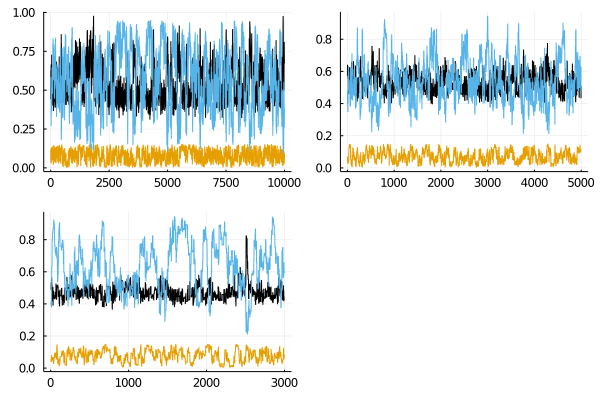

In [1078]:
p1 = Plots.plot(samples_25y[1,:], label = "")
Plots.plot!(p1,samples_25y[2,:], label = "")
Plots.plot!(p1,samples_25y[3,:], label = "")

p2 = Plots.plot(samples_50y[1,:], label = "")
Plots.plot!(p2,samples_50y[2,:], label = "")
Plots.plot!(p2,samples_50y[3,:], label = "")

p3 = Plots.plot(samples_75y[1,:], label = "")
Plots.plot!(p3,samples_75y[2,:], label = "")
Plots.plot!(p3,samples_75y[3,:], label = "")

plot(p1,p2,p3)

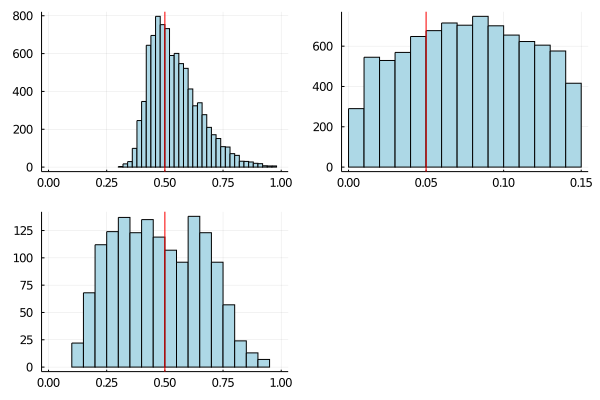

In [1099]:
p1 = Plots.histogram(samples_25y[1,1000:10000], xlim = [0,1],label = "",  color ="lightblue")
Plots.vline!(p1, [p_im], label = "", color ="red")

p2 = Plots.histogram(samples_25y[2,1000:10000], xlim = [0,0.15], label = "",  color ="lightblue")
Plots.vline!(p2,[s], label = "", color ="red")
p3 = Plots.histogram(samples_25y[3,500:2000], xlim = [0,1], label = "",  color ="lightblue")
Plots.vline!(p3,[RRS], label = "", color ="red")
plot(p1,p2,p3)

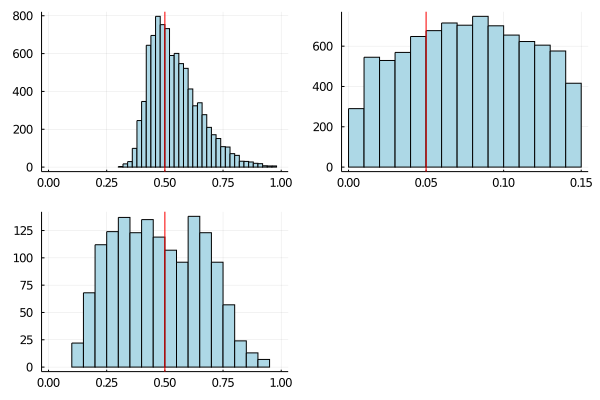

In [1100]:
p4 = Plots.histogram(samples_50y[1,1000:5000], xlim = [0,1],label = "", color ="lightblue")
Plots.vline!(p4, [p_im], label = "", color ="red")

p5 = Plots.histogram(samples_50y[2,1000:5000], xlim = [0,0.15], label = "",  color ="lightblue")
Plots.vline!(p5,[s], label = "", color ="red")
p6 = Plots.histogram(samples_50y[3,1000:5000], xlim = [0,1], label = "", color ="lightblue")
Plots.vline!(p6,[RRS], label = "", color ="red")
plot(p1,p2,p3)

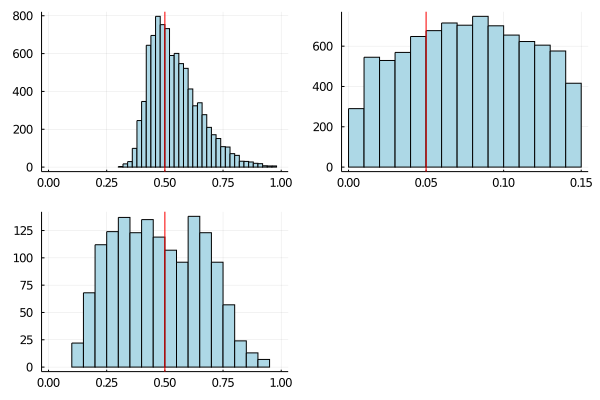

In [1101]:
p7 = Plots.histogram(samples_75y[1,1000:3000], xlim = [0,1],label = "", color ="lightblue")
Plots.vline!(p7, [p_im], label = "", color ="red")

p8 = Plots.histogram(samples_75y[2,1000:3000], xlim = [0,0.15], label = "",  color ="lightblue")
Plots.vline!(p8,[s], label = "", color ="red")
p9 = Plots.histogram(samples_75y[3,1000:3000], xlim = [0,1], label = "", color ="lightblue")
Plots.vline!(p9,[RRS], label = "", color ="red")
plot(p1,p2,p3)

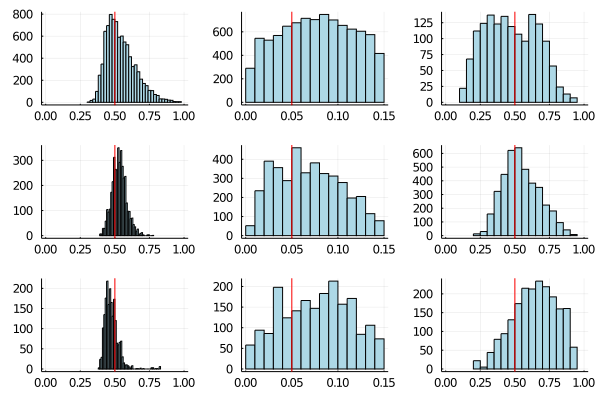

In [1102]:
plot(p1,p2,p3,p4,p5,p6,p7,p8,p9, layout = (3,3))

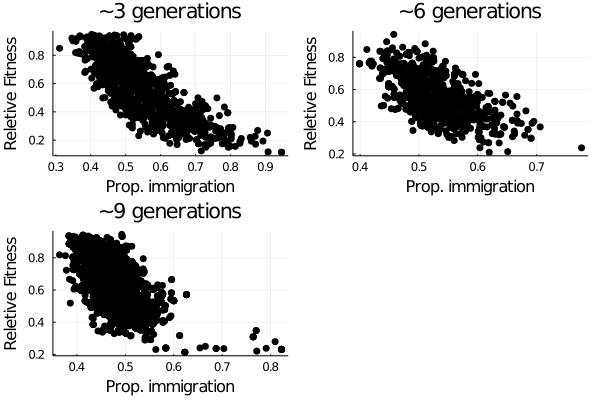

In [1098]:
b_in = 1
inds = rand(1000:10000,1000)
p1 = Plots.scatter(samples_25y[1,inds],samples_25y[3,inds], ylabel = "Reletive Fitness",
    xlabel = "Prop. immigration", title = "~3 generations", label = "")
inds = rand(1000:5000,1000)
p2 = Plots.scatter(samples_50y[1,inds],samples_50y[3,inds], ylabel = "Reletive Fitness", 
    xlabel = "Prop. immigration", title = "~6 generations", label = "")
p3 = Plots.scatter(samples_75y[1,b_in:3000],samples_75y[3,b_in:3000], ylabel = "Reletive Fitness", 
    xlabel = "Prop. immigration", title = "~9 generations", label = "")
plot(p1,p2,p3)

In [981]:
using JLD2

In [982]:
@save "data/MCMC_samples_50y.jld" samples_50y 

# Visualize Partical Filter

In [940]:
# organize data and set parameters 
include("ParticleFilters.jl")
T_end = 50
agestructure = mod1
Nt = Nt
time_step! = pedigreeAproximation.time_step_DSI!
t_pedigree = time_steps_pedigree
t_recruitsN = time_steps_recruitsN
t_recruitsH = time_steps_recruitsH 

pedigrees = data_pedigree # broadcast(x -> x[1:n],data_pedigree)
recruitsN = data_recruitsN
recruitsH = data_recruitsH
presc = 1.0

data = ParticleFilters.data(T_end,agestructure,Nt,time_step!,t_pedigree,t_recruitsN,t_recruitsH,
                            pedigrees,recruitsN,recruitsH,presc)

p_im = 0.2
s = 0.05
RRS = 0.5
p_spawn = 1.0

params = ParticleFilters.params(p_im,s,RRS,p_spawn)



### evaluate likelihood ###

# number of particles and accumulators
n = 4
N_particles = 1000
pedigree_ls = broadcast(i -> zeros(data.T_end),1:N_particles)
pedigree_re = broadcast(i -> zeros(data.T_end),1:N_particles)
t_steps = zeros(2*data.T_end)


pop1 = pedigreeAproximation.init_population(mod1,  θ, s,n,1.0)
StockRecruitCurves.update_BevetonHolt_k!(pop1.ageStructure.SRCurve, k)
pedigree_pop1 = zeros(data.T_end)

# Convert RRS to mu_im
mu_im = AgeTraitStructuredModels.solve_trait_difference(params.RRS,params.s)

# initialize particles
logLik = 0.0
logLikls = zeros(N_particles)
populaitons = []
for i in 1:N_particles
    push!(populaitons, pedigreeAproximation.init_population(data.ageStructure,  0.0, params.s, n, params.p_spawn))
end 
    
pf = ParticleFilters.particleFilter(N_particles,logLikls,populaitons)
t_data = unique(vcat(data.t_pedigree,data.t_recruitsN,data.t_recruitsH))

        



for t in 1:data.T_end

    
    
    if data.Nt[t] > 0
        data.time_step!(pop1, rand(Distributions.Binomial(data.Nt[t], params.p_im)), mu_im) 
    else
        data.time_step!(pop1, 0, mu_im) 
    end
    pedigree_pop1[t] = sum(pop1.pi[:,1] .* (0:(2^n))./(2^n)) 
    # update particles
    for i in 1:N_particles

        if data.Nt[t] > 0
            data.time_step!(populaitons[i], rand(Distributions.Binomial(data.Nt[t], params.p_im)), mu_im) 
        else
            data.time_step!(populaitons[i], 0, mu_im) 
        end


        ## pedigress
        if t in data.t_pedigree
            pf.logLik[i] += ParticleFilters.recruits_pedigree(data.pedigrees[data.t_pedigree .== t][1],pf.particles[i])
        end 


        # natrual recruitment
        if t in data.t_recruitsN
            pf.logLik[i] += ParticleFilters.recruitsH(data.recruitsN[data.t_recruitsN .== t][1],data.precision,pf.particles[i])
        end 



        # hatchery migation
        if t in data.t_recruitsH
            pf.logLik[i] += ParticleFilters.recruitsH(data.recruitsH[data.t_recruitsH .== t][1],data.precision,pf.particles[i])
        end 
        

        pedigree_ls[i][t] = sum(pf.particles[i].pi[:,1] .* (0:(2^n))./(2^n))

    end 

    
    # likelihood estiamte
    logLik += sum(pf.logLik)/pf.N

    
    
    # resample particles 
    ParticleFilters.resample_particle_state!(pf) 
        
    for i in 1:N_particles
        pedigree_re[i][t] = sum(pf.particles[i].pi[:,1] .* (0:(2^n))./(2^n))          
    end 
            
            
end 
        
println(logLik )

-1018.3300513001992


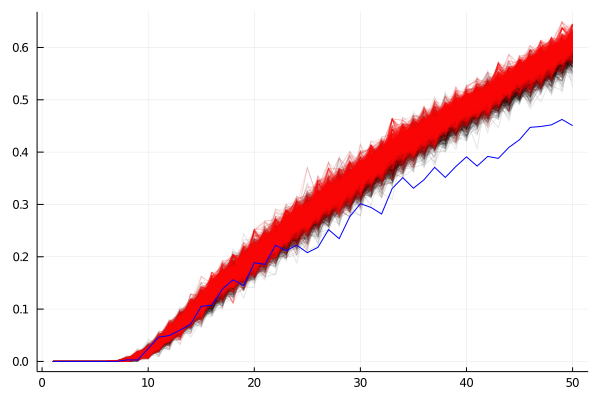

In [941]:
p1 = Plots.plot(pedigree_ls[1], color = "black", alpha = 0.1)
for i in 2:N_particles
    Plots.plot!(p1,pedigree_ls[i], color = "black", alpha = 0.1)
end
Plots.plot!(p1, pedigree_re[1], color = "red", alpha = 0.1)
for i in 2:N_particles
    Plots.plot!(p1, pedigree_re[i], color = "red", alpha = 0.1, legend =:none)
end
Plots.plot!(p1,pedigree_pop1, color = "blue")